In [73]:
import matplotlib.pyplot as plt
import json
import numpy
from scipy.signal import find_peaks, peak_widths, lfilter, lfilter_zi, filtfilt, butter

In [2]:
def load_json(path):
    with open(path, "r") as json_file:
        return json.loads(json_file.read())

In [6]:
intersection_area_over_time = load_json("/Users/gvieira/shan/video-42-p_03/iaot.json")
track_index = 0
roi_name = "area_in_front_of_left_shelf"

In [7]:
   # Example:
    #
    # [{                    -> track_index = 0
    #     "roi_1": [{       -> roi_name = "roi_1"
    #         "index": 4,   -> index of the frame in the video
    #         "area": 0,    -> intersection area
    #         "bbox": null  -> bbox of the intersection area
    #     }, {
    #         "index": 5,
    #         "area": 0,
    #         "bbox": null
    # ...
    #

In [8]:
iaot = intersection_area_over_time[track_index][roi_name]
X = []
Y = []
for i in range(len(iaot)):
    X.append(iaot[i]["index"])
    Y.append(iaot[i]["area"])

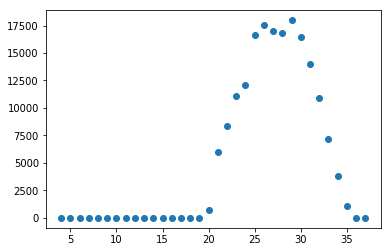

In [9]:
plt.scatter(X, Y)

# Filtering with delay

In [20]:
# SOURCE:
# http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
#
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y


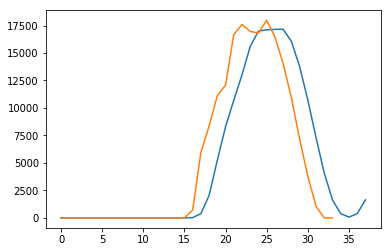

In [69]:
x = numpy.array(X)
y = numpy.array(Y)
smooth_y = smooth(y, window_len=5, window="hamming")
plt.plot(smooth_y)
plt.plot(y)

In [70]:
peaks, _ = find_peaks(smooth_y)
widths, _, _, _ = peak_widths(smooth_y, peaks)

In [72]:
{"peaks": peaks, "height": smooth_y[peaks[0]], "width": widths[0]}

{'height': 17159.375, 'peaks': array([27]), 'width': 10.485768135291938}

# Filtering without delay

In [86]:
def smooth_without_delay(xn):
    b, a = butter(1, 0.30)
    # Apply the filter to xn.  Use lfilter_zi to choose the initial condition
    # of the filter.
    zi = lfilter_zi(b, a)
    z, _ = lfilter(b, a, xn, zi=zi*xn[0])
    # Apply the filter again, to have a result filtered at an order
    # the same as filtfilt.
    z2, _ = lfilter(b, a, z, zi=zi*z[0])
    # Use filtfilt to apply the filter.
    return filtfilt(b, a, xn)

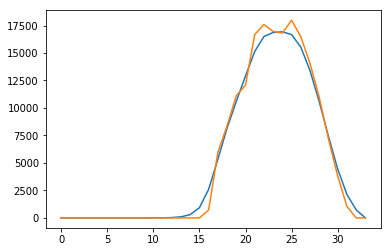

In [89]:
x = numpy.array(X)
y = numpy.array(Y)
smooth_y = smooth_without_delay(y)
plt.plot(smooth_y)
plt.plot(y)

In [99]:
indexes, props = find_peaks(smooth_y, height=10000, width=7)

MIN_DURATION_MS_FOR_INTERACTED = 1500
MIN_INTERSECTION_AREA_PX_FOR_INTERACTED = 5000
fps = 5

events = []

for i in range(len(indexes)):
    frame_index = indexes[i]
    duration_in_frames = props["widths"][i]
    intersection_area_in_pixels = props["peak_heights"][i]
    
    duration_ms = int(1000 * (duration_in_frames / fps))
    if duration_ms > MIN_DURATION_MS_FOR_INTERACTED and intersection_area_in_pixels > MIN_INTERSECTION_AREA_PX_FOR_INTERACTED:
        events.append({
            "frame_index": frame_index,
            "event_type": "interacted"
        })

events

[{'event_type': 'interacted', 'frame_index': 24}]